**Measuring Bias in classification**


In [ ]:
!pip install holisticai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.8/272.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.insert(0,"/mnt/d/holisticai/repos/holisticai")

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

**Dataset** : The Law School dataset.

The goal of this dataset is the prediction of the binary attribute 'bar' that is whether a student passes the law school bar.

The protected attributes are race and gender.

In [ ]:
from holisticai.datasets import load_law_school
df = load_law_school()['frame']
df

,age,decile1,decile3,fam_inc,lsat,ugpa,gender,race1,cluster,fulltime,bar,ugpagt3
0,62.0,10.0,10.0,5.0,44.0,3.5,female,white,1,1,TRUE,1.0
1,62.0,5.0,4.0,4.0,29.0,3.5,female,white,2,1,TRUE,1.0
2,61.0,8.0,7.0,3.0,37.0,3.4,male,white,1,1,TRUE,1.0
3,60.0,8.0,7.0,4.0,43.0,3.3,female,white,1,1,TRUE,1.0
4,57.0,3.0,2.0,4.0,41.0,3.3,female,white,4,1,TRUE,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20795,60.0,9.0,8.0,4.0,42.0,3.0,male,white,5,1,TRUE,0.0
20796,61.0,4.0,9.0,4.0,29.5,3.5,male,white,3,1,TRUE,1.0
20797,62.0,1.0,1.0,3.0,33.0,3.1,male,non-white,3,1,FALSE,1.0
20798,65.0,4.0,5.0,3.0,32.0,3.0,male,white,3,2,TRUE,0.0


In [ ]:
df.isnull().sum()

age         0
decile1     0
decile3     0
fam_inc     0
lsat        0
ugpa        0
gender      0
race1       0
cluster     0
fulltime    0
bar         0
ugpagt3     0
dtype: int64

**Data Exploration**

<Axes: >

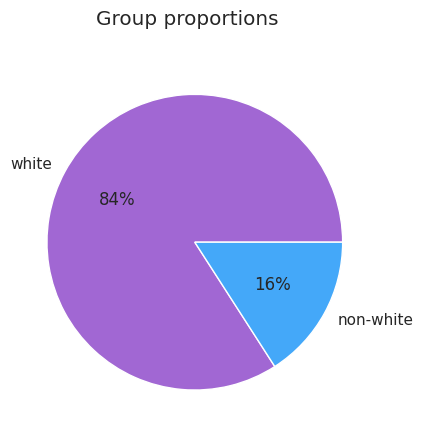

In [ ]:
from holisticai.bias.plots import group_pie_plot, frequency_plot
p_attr = df['race1'] # protected attribute (race)
y = df['bar']        # binary label vector
group_pie_plot(p_attr)

<Axes: xlabel='Group', ylabel='Frequency'>

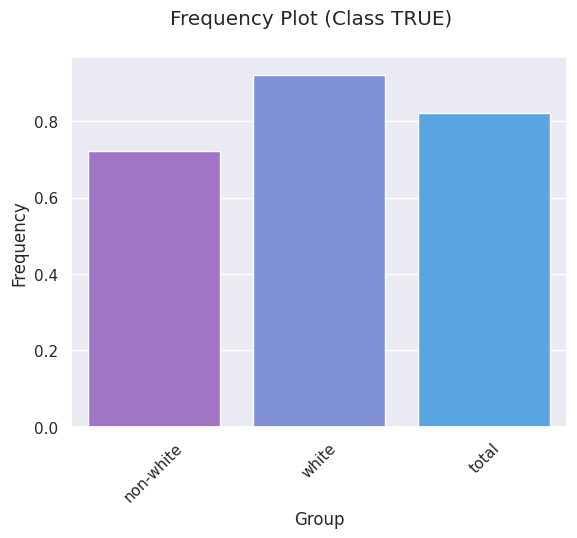

In [ ]:
frequency_plot(p_attr, y)

**Inference:**

The proportion of white people in law school is very high.
Also the white group has a much higher pass rate than the non-white group.



**Train a model**

In [ ]:
# simple preprocessing before training.
df_enc = df.copy()
df_enc['bar'] = df_enc['bar'].replace({'FALSE':0, 'TRUE':1})

#Logistic Regression classifier.

from sklearn.model_selection import train_test_split

# split features and target, then train test split
X = df_enc.drop(columns=['bar', 'ugpagt3'])
y = df_enc['bar']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# train a model, standard scale data
scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train.drop(columns=['race1', 'gender']))
LR = LogisticRegression(random_state=42, max_iter=500)
LR.fit(X_train_t, y_train)
X_test_t = scaler.transform(X_test.drop(columns=['race1', 'gender']))
y_pred = LR.predict(X_test_t)
from holisticai.efficacy.metrics import classification_efficacy_metrics

classification_efficacy_metrics(y_pred, y_test)

,Value,Reference
Metric,,
Accuracy,0.902724,1
Balanced Accuracy,0.775417,1
Precision,0.984372,1
Recall,0.913333,1
F1-Score,0.947523,1


**Measure bias**


In [ ]:
from holisticai.bias.metrics import statistical_parity
from holisticai.bias.metrics import disparate_impact
from holisticai.bias.metrics import accuracy_diff
# set up groups, prediction array and true (target/label) array.
group_a = X_test["race1"]=='non-white'  # non-white vector
group_b = X_test["race1"]=='white'      # white vector
y_pred  = LR.predict(X_test_t)          # prediction vector
y_true  = y_test                        # true vector
p_attr = X_test["race1"]

In [ ]:
statistical_parity(group_a, group_b, y_pred)

-0.1583838383838384

In [ ]:
disparate_impact(group_a, group_b, y_pred)

0.8394758394758395

In [ ]:
accuracy_diff(group_a, group_b, y_pred, y_true)

-0.12809812409812404

**Statistical parity** indicates the difference in success rate between non-white and white groups. In this case it is outside of ranges considered fair (-0.1, 0.1).


**Disparate impact** on the other hand is within the fair range (0.8, 1.2).


**Accuracy difference** is an equality of opportunity metric. A value of -0.12 shows that the classifier is less accurate on non-white group than white group.



In [ ]:
from holisticai.bias.metrics import classification_bias_metrics
classification_bias_metrics(group_a, group_b, y_pred, y_true, metric_type='equal_outcome')

,Value,Reference
Metric,,
Statistical Parity,-0.158384,0
Disparate Impact,0.839476,1
Four Fifths Rule,0.839476,1
Cohen D,-0.863802,0
2SD Rule,-23.769452,0


In [ ]:
classification_bias_metrics(group_a, group_b, y_pred, y_true, metric_type='equal_opportunity')

,Value,Reference
Metric,,
Equality of Opportunity Difference,-0.069042,0
False Positive Rate Difference,-0.344579,0
Average Odds Difference,-0.206811,0
Accuracy Difference,-0.128098,0


The false positive rate difference of 0.34 hints that white people are more likely to be missclassified as passing the bar than non-whites.


**Bias measuring and mitigation in classification tasks**

**1. Data loading**

**Dataset** :Adult dataset

Contains information about age, education, marital status, race and gender of individuals from the United States. The objective is to predict whether an individual's income will be above or below $50K per year.

**Source:** UCI ML repository

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from holisticai.datasets import load_adult

np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

data = load_adult()
df = pd.concat([data["data"], data["target"]], axis=1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [ ]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


**2. Dataset preprocessing**

In [ ]:
data['data'].isna().sum(), data['data'].shape

(age                  0
 workclass         2799
 fnlwgt               0
 education            0
 education-num        0
 marital-status       0
 occupation        2809
 relationship         0
 race                 0
 sex                  0
 capital-gain         0
 capital-loss         0
 hours-per-week       0
 native-country     857
 dtype: int64,
 (48842, 14))

In [ ]:
def preprocess_adult_dataset(df):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()
  # Get the protected attribute vectors
  group_a = df_clean["sex"] == "Female"
  group_b = df_clean["sex"] == "Male"

  group_a = np.squeeze(group_a.values)
  group_b = np.squeeze(group_b.values)
  # Remove unnecessary columns
  df_clean["class"].replace({">50K": 1, "<=50K": 0}, inplace=True)
  tmp = pd.get_dummies(df_clean.drop(columns=["sex", "race", "education", "class"]))
  df_clean = pd.concat([tmp, df_clean["class"].astype("uint8")], axis=1)
  return df_clean, group_a, group_b

In [ ]:
df_clean, group_a, group_b = preprocess_adult_dataset(df)

In [ ]:
df.shape, df_clean.shape

((48842, 15), (47985, 61))

**3. Data analysis**

**group_pie_plot** : this function will plot the distribution of the data of the protected groups in a pie chart.

The graph show us that the proportion of male (labelled as False) is high compared to the female.

<Axes: >

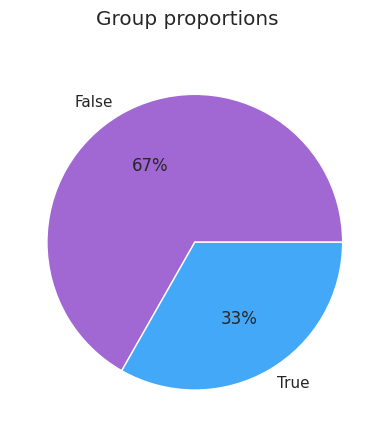

In [ ]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(group_a)

In [ ]:
X = df_clean.iloc[:,:-1].values
y = df_clean.iloc[:,-1].values

X.shape, y.shape

((47985, 60), (47985,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

**4. Model training**


In [ ]:
# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from holisticai.pipeline import Pipeline
# efficacy metrics from sklearn
from sklearn import metrics

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,
        "Precision": metrics.precision_score,
        "Recall": metrics.recall_score,
        "F1-Score": metrics.f1_score}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train a simple linear classification model
LR = LogisticRegression()
model = LR.fit(X, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

# Predict values
y_pred = model.predict(X)

y_proba = model.predict_proba(X)
y_score = y_proba[:,1]
y_true = y
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.840471
Balanced accuracy,0.748136
Precision,0.696726
Recall,0.573322
F1-Score,0.629028


**5. Bias measuring**

**classification_bias_metrics**: function allows us to select which metrics we want to calculate, if equal_outcome, equal_opportunity or both, where equal_outcome shows how disadvantaged groups are treated by the model and equal_opportunity shows if all the groups have the same opportunities.

In [ ]:
from holisticai.bias.metrics import classification_bias_metrics
df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
y_baseline = y_pred.copy()
df_baseline=df.copy()
df_baseline

,Value,Reference
Metric,,
Statistical Parity,-0.175836,0
Disparate Impact,0.304267,1
Four Fifths Rule,0.304267,1
Cohen D,-0.454655,0
2SD Rule,-20.530369,0
Equality of Opportunity Difference,-0.126491,0
False Positive Rate Difference,-0.082923,0
Average Odds Difference,-0.104707,0
Accuracy Difference,0.112691,0



**Statistical parity:** Computes the difference in success rates between the protected groups. Values below 0 are considered unfair towards group_a while values above 0 are considered unfair towards group_b, the range (-0.1, 0.1) is considered acceptable.

**Disparate Impact:** Shows the ratio of success rates between the protected groups for a certain quantile. Values below 1 are unfair towards group_a. Values above 1 are unfair towards group_b. The range (0.8, 1.2) is considered acceptable.

**Four Fifths:** Computes the ratio of success rates between the protected groups. Values below 1 are considered unfair while a range between (0.8, 1) is considered acceptable.

**Cohen D:** Computes the normalised statistical parity between the protected groups. Values below 0 are considered unfair towards group_a while values above 0 are considered unfair towards group_b.

**Equality of opportunity difference:** Computes the difference in true positive rates between the protected groups. Values below 0 are considered unfair towards group_a while values above 0 are considered unfair towards group_b.

**False positive rate difference:** Computes the difference in false positive rates between the protected groups, negative values indicating bias against group_a while positive values indicating bias against group_b.

**Average Odds Difference:** Computes the difference in average odds between the protected groups, negative values indicating bias against group_a while positive values indicating bias against group_b, a range between (-0.1, 0.1) is considered acceptable.

**Accuracy Difference:** Computes the difference in accuracy of predictions for the protected groups, positive values show bias against group_b while negative values show bias against group_a.


**6.a Bias mitigation**

**Correlation remover:** is a pre-processing technique that applies a linear transformation to the non-sensitive features of the dataset to remove the correlation with respect to the sensitive columns. This process is done aiming to maintain as much as possible to prevent lost information.

**Traditional implementation**

In [ ]:
from holisticai.bias.mitigation import CorrelationRemover
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = CorrelationRemover()

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression()

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem = df.copy()
df_corr_rem

,Value,Reference
Metric,,
Statistical Parity,-0.113786,0
Disparate Impact,0.474747,1
Four Fifths Rule,0.474747,1
Cohen D,-0.299963,0
2SD Rule,-13.716201,0
Equality of Opportunity Difference,0.021647,0
False Positive Rate Difference,-0.039364,0
Average Odds Difference,-0.008859,0
Accuracy Difference,0.106908,0


**Pipeline implementation**

In [ ]:
model = LogisticRegression()
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", model),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem_w_p =df.copy()
df_corr_rem_w_p

,Value,Reference
Metric,,
Statistical Parity,-0.113786,0
Disparate Impact,0.474747,1
Four Fifths Rule,0.474747,1
Cohen D,-0.299963,0
2SD Rule,-13.716201,0
Equality of Opportunity Difference,0.021647,0
False Positive Rate Difference,-0.039364,0
Average Odds Difference,-0.008859,0
Accuracy Difference,0.106908,0


In [ ]:
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.838387
Balanced accuracy,0.733949
Precision,0.707872
Recall,0.536219
F1-Score,0.610204


**7.a Results comparison**

In [ ]:
result = pd.concat([df_baseline, df_corr_rem, df_corr_rem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Statistical Parity,-0.175836,-0.113786,-0.113786,0
Disparate Impact,0.304267,0.474747,0.474747,1
Four Fifths Rule,0.304267,0.474747,0.474747,1
Cohen D,-0.454655,-0.299963,-0.299963,0
2SD Rule,-20.530369,-13.716201,-13.716201,0
Equality of Opportunity Difference,-0.126491,0.021647,0.021647,0
False Positive Rate Difference,-0.082923,-0.039364,-0.039364,0
Average Odds Difference,-0.104707,-0.008859,-0.008859,0
Accuracy Difference,0.112691,0.106908,0.106908,0


alpha - parameter to control how much to filter, for alpha=1.0 we filter out all information while for alpha=0.0 we don’t apply any.

In [ ]:
def calculate_metrics(train_data, test_data, alpha, metrics_cols):
  from sklearn.metrics import accuracy_score
  model = LogisticRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", CorrelationRemover(alpha=alpha)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  df = classification_bias_metrics(
      group_a,
      group_b,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      alpha,
      accuracy_score(y, y_pred)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Statistical Parity', 'Disparate Impact']

for alphas in np.linspace(0,1.5,12):
  metrics_val.append(calculate_metrics(train_data, test_data, alphas, metrics_cols))

metrics = ['alpha', 'accuracy']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,alpha,accuracy,Statistical Parity,Disparate Impact
0,0.000000,0.840471,-0.175836,0.304267
1,0.136364,0.840263,-0.173804,0.311029
2,0.272727,0.840471,-0.171304,0.315855
3,0.409091,0.840679,-0.165052,0.332491
4,0.545455,0.839742,-0.157549,0.348837
5,0.681818,0.839429,-0.146921,0.375830
6,0.818182,0.840158,-0.136136,0.405461
7,0.954545,0.839533,-0.121444,0.449327
8,1.090909,0.836616,-0.097999,0.531040
9,1.227273,0.833906,-0.067990,0.651721


Text(0.5, 0, 'alpha')

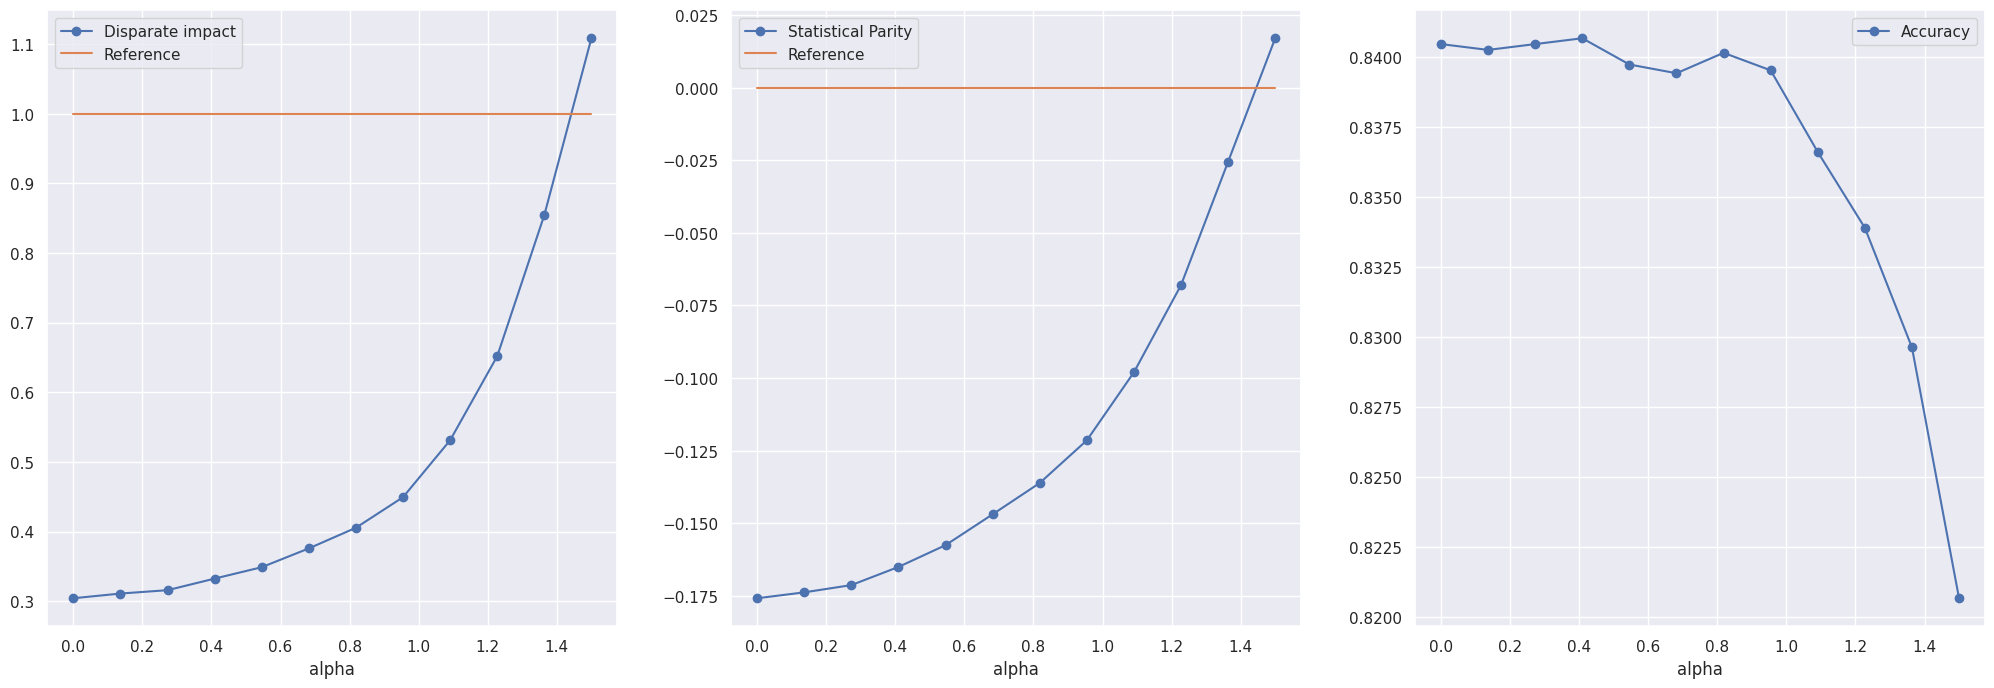

In [ ]:
x_axis = df_metrics.alpha
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Disparate Impact'], 'o-', label='Disparate impact')
plt.plot(x_axis, np.ones_like(df_metrics['Disparate Impact']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Statistical Parity'], 'o-', label='Statistical Parity')
plt.plot(x_axis, np.zeros_like(df_metrics['Statistical Parity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(133)
plt.plot(x_axis, df_metrics['accuracy'], 'o-', label='Accuracy')
plt.legend(loc='upper right')
plt.xlabel('alpha')

As we can see, the variation of this parameter shows that when we increase its value the results are closer to the reference, but we need into account that the higher the value of the parameter is, the more information will be filtered but the accuracy will be also affected. In general, the selection of the model parameters will depend on our main objective, whether we are looking for fairness or accuracy.

**6.b Bias mitigation**

**Disparate impact remover:** is a pre-processing technique that uses perturbation to modify the values of the features such that the distributions of privileged and unprivileged groups are close in order to increase fairness.

**Traditional implementation**

In [ ]:
from holisticai.bias.mitigation import DisparateImpactRemover
from sklearn.preprocessing import StandardScaler,MinMaxScaler

X, y, group_a, group_b = train_data

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = DisparateImpactRemover(repair_level=1.0)

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression(class_weight='balanced', solver='liblinear')

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_disprem = df.copy()
df_disprem

,Value,Reference
Metric,,
Statistical Parity,-0.364176,0
Disparate Impact,0.330844,1
Four Fifths Rule,0.330844,1
Cohen D,-0.786175,0
2SD Rule,-34.043717,0
Equality of Opportunity Difference,-0.135594,0
False Positive Rate Difference,-0.289753,0
Average Odds Difference,-0.212673,0
Accuracy Difference,0.187246,0


In [ ]:
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.756382
Balanced accuracy,0.799059
Precision,0.490882
Recall,0.879859
F1-Score,0.630180


**Pipeline implementation**

In [ ]:
model = LogisticRegression(class_weight='balanced', solver='liblinear')
pipeline = Pipeline(
    steps=[
        ('scalar', MinMaxScaler()),
        ("bm_preprocessing", DisparateImpactRemover()),
        ("model", model),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_disprem_w_p =df.copy()
df_disprem_w_p

,Value,Reference
Metric,,
Statistical Parity,-0.364176,0
Disparate Impact,0.330844,1
Four Fifths Rule,0.330844,1
Cohen D,-0.786175,0
2SD Rule,-34.043717,0
Equality of Opportunity Difference,-0.135594,0
False Positive Rate Difference,-0.289753,0
Average Odds Difference,-0.212673,0
Accuracy Difference,0.187246,0


In [ ]:
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.756382
Balanced accuracy,0.799059
Precision,0.490882
Recall,0.879859
F1-Score,0.630180


**7.b Results comparison**

In [ ]:
result = pd.concat([df_baseline, df_disprem, df_disprem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Statistical Parity,-0.175836,-0.364176,-0.364176,0
Disparate Impact,0.304267,0.330844,0.330844,1
Four Fifths Rule,0.304267,0.330844,0.330844,1
Cohen D,-0.454655,-0.786175,-0.786175,0
2SD Rule,-20.530369,-34.043717,-34.043717,0
Equality of Opportunity Difference,-0.126491,-0.135594,-0.135594,0
False Positive Rate Difference,-0.082923,-0.289753,-0.289753,0
Average Odds Difference,-0.104707,-0.212673,-0.212673,0
Accuracy Difference,0.112691,0.187246,0.187246,0


In [ ]:
def calculate_metrics(train_data, test_data, repair_level, metrics_cols):
  from sklearn.metrics import accuracy_score
  model = LogisticRegression(class_weight='balanced', solver='liblinear')
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", DisparateImpactRemover(repair_level=repair_level)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  df = classification_bias_metrics(
      group_a,
      group_b,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      repair_level,
      accuracy_score(y, y_pred)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Statistical Parity', 'Disparate Impact']

for repair_values in np.linspace(0,1,11):
  metrics_val.append(calculate_metrics(train_data, test_data, repair_values, metrics_cols))

metrics = ['repair_value', 'Accuracy']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,repair_value,Accuracy,Statistical Parity,Disparate Impact
0,0.0,0.792539,-0.314630,0.337175
1,0.1,0.793581,-0.308534,0.342000
2,0.2,0.794623,-0.304783,0.344758
3,0.3,0.794623,-0.303063,0.347358
4,0.4,0.796186,-0.295405,0.353183
5,0.5,0.796812,-0.294154,0.355921
6,0.6,0.808794,-0.289153,0.325802
7,0.7,0.809420,-0.281807,0.334932
8,0.8,0.810357,-0.274930,0.341938
9,0.9,0.812233,-0.262582,0.353846


Text(0.5, 0, 'repair_value')

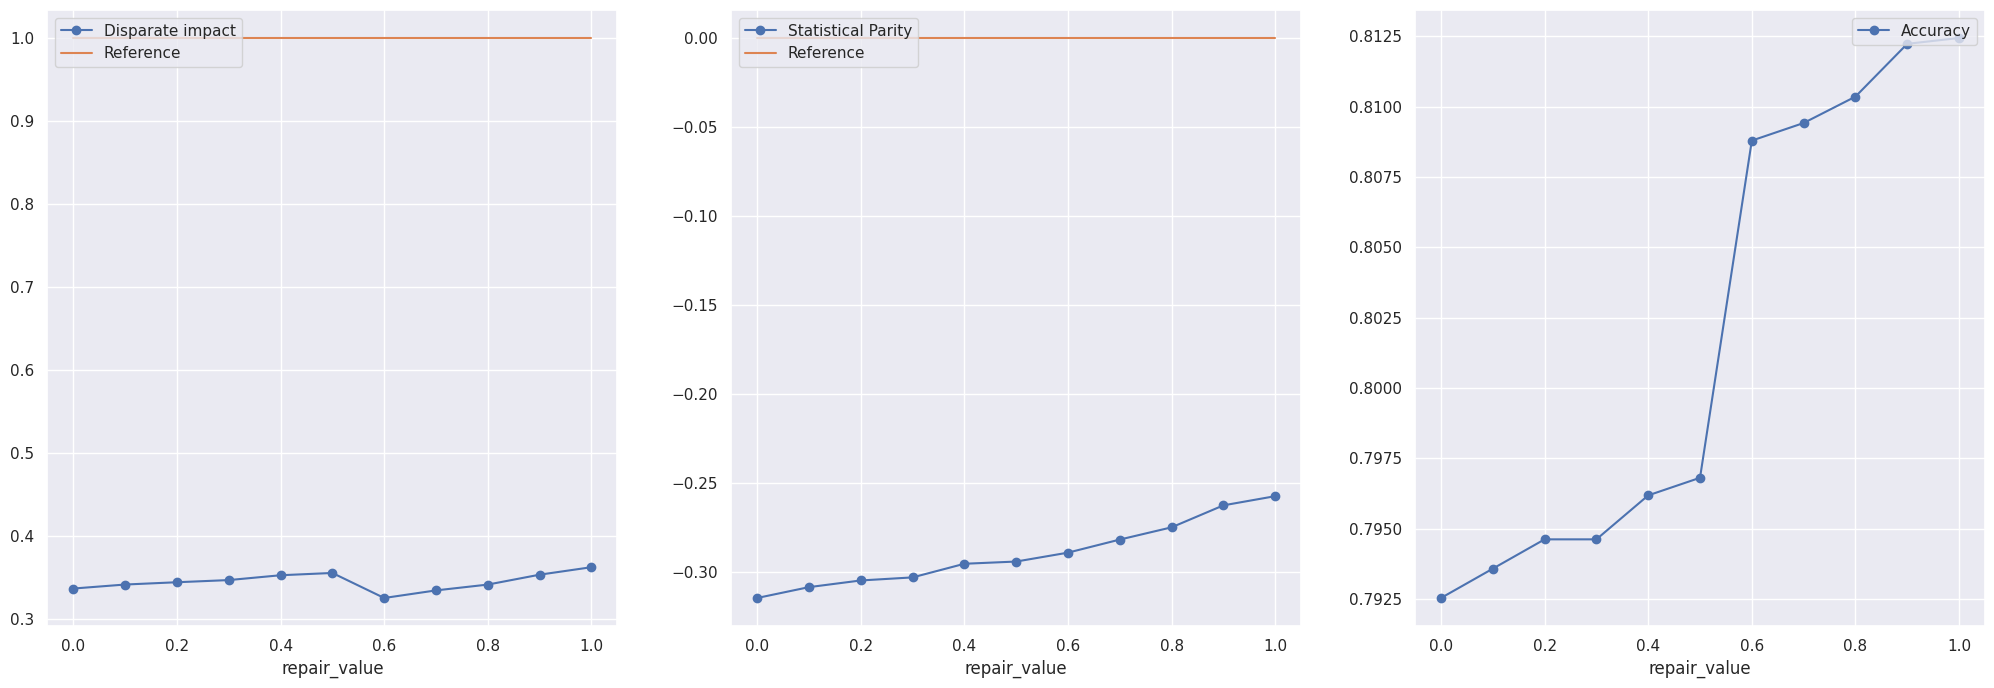

In [ ]:
x_axis = df_metrics.repair_value
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Disparate Impact'], 'o-', label='Disparate impact')
plt.plot(x_axis, np.ones_like(df_metrics['Disparate Impact']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('repair_value')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Statistical Parity'], 'o-', label='Statistical Parity')
plt.plot(x_axis, np.zeros_like(df_metrics['Statistical Parity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('repair_value')
plt.subplot(133)
plt.plot(x_axis, df_metrics['Accuracy'], 'o-', label='Accuracy')
plt.legend(loc='upper right')
plt.xlabel('repair_value')

Dataset : Titanic dataset

Source : https://www.kaggle.com/datasets/brendan45774/test-file

In [ ]:
import pandas as pd
df=pd.read_csv("/content/tested.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,0.363636,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.481622,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,1.000000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [ ]:
df.isna().sum(), df.shape

(PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age             86
 SibSp            0
 Parch            0
 Ticket           0
 Fare             1
 Cabin          327
 Embarked         0
 dtype: int64,
 (418, 12))

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def preprocess_adult_dataset(df):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_=df_.drop(columns=["Name", "Cabin"])
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()
  # Get the protected attribute vectors
  group_a = df_clean["Sex"] == "female"
  group_b = df_clean["Sex"] == "male"

  group_a = np.squeeze(group_a.values)
  group_b = np.squeeze(group_b.values)
  # Remove unnecessary columns
  tmp = pd.get_dummies(df_clean["Embarked"])
  df_clean['Ticket']= le.fit_transform(df_clean['Ticket'])
  df_clean = pd.concat([df_clean["PassengerId"],df_clean["Pclass"],	df_clean["Age"], df_clean["SibSp"], df_clean["Parch"],	df_clean['Ticket'] ,	df_clean["Fare"],tmp, df_clean["Survived"].astype("uint8")], axis=1)
  return df_clean, group_a, group_b

In [ ]:
df_clean, group_a, group_b = preprocess_adult_dataset(df)

In [ ]:
df.shape, df_clean.shape

((418, 12), (331, 11))

In [ ]:
df_clean.head()

,PassengerId,Pclass,Age,SibSp,Parch,Ticket,Fare,C,Q,S,Survived
0,892,3,34.5,0,0,128,7.8292,0,1,0,0
1,893,3,47.0,1,0,181,7.0000,0,0,1,1
2,894,2,62.0,0,0,63,9.6875,0,1,0,0
3,895,3,27.0,0,0,124,8.6625,0,0,1,0
4,896,3,22.0,1,1,115,12.2875,0,0,1,1


<Axes: >

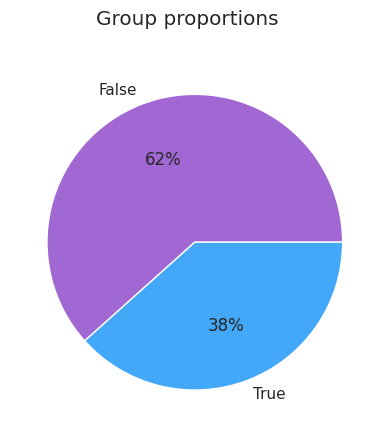

In [ ]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(group_a)

In [ ]:
group_b.size

331

In [ ]:
df_clean

,PassengerId,Pclass,Age,SibSp,Parch,Ticket,Fare,C,Q,S,Survived
0,892,3,34.5,0,0,128,7.8292,0,1,0,0
1,893,3,47.0,1,0,181,7.0000,0,0,1,1
2,894,2,62.0,0,0,63,9.6875,0,1,0,0
3,895,3,27.0,0,0,124,8.6625,0,0,1,0
4,896,3,22.0,1,1,115,12.2875,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
409,1301,3,3.0,1,1,273,13.7750,0,0,1,1
411,1303,1,37.0,1,0,40,90.0000,0,1,0,1
412,1304,3,28.0,0,0,150,7.7750,0,0,1,1
414,1306,1,39.0,0,0,251,108.9000,1,0,0,1


In [ ]:
X = df_clean.iloc[:,:-1].values
y = df_clean.iloc[:,-1].values

X.shape, y.shape

((331, 10), (331,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

In [ ]:
y_train.size

53

In [ ]:
# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from holisticai.pipeline import Pipeline
# efficacy metrics from sklearn
from sklearn import metrics

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,
        "Precision": metrics.precision_score,
        "Recall": metrics.recall_score,
        "F1-Score": metrics.f1_score}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train a simple linear classification model
LR = LogisticRegression()
model = LR.fit(X, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

# Predict values
y_pred = model.predict(X)

y_proba = model.predict_proba(X)
y_score = y_proba[:,1]
y_true = y
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.642857
Balanced accuracy,0.530303
Precision,0.250000
Recall,0.333333
F1-Score,0.285714


In [ ]:
from holisticai.bias.metrics import classification_bias_metrics
df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
y_baseline = y_pred.copy()
df_baseline=df.copy()
df_baseline

,Value,Reference
Metric,,
Statistical Parity,0.060606,0
Disparate Impact,1.222222,1
Four Fifths Rule,0.818182,1
Cohen D,0.134738,0
2SD Rule,0.205971,0
Equality of Opportunity Difference,0.333333,0
False Positive Rate Difference,-0.272727,0
Average Odds Difference,0.030303,0
Accuracy Difference,-0.393939,0


In [ ]:
train_data[0].size

530

In [ ]:
from sklearn.metrics import confusion_matrix
from holisticai.bias.mitigation import CorrelationRemover
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = CorrelationRemover()

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression()

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)



conf_matrix = confusion_matrix(y_true[group_b == 1], y_pred[group_b == 1], normalize="true")

if conf_matrix.shape[0] > 1:
    tpr_b = conf_matrix[1, 1]
else:
    tpr_b = 0.0

tpr_b

0.0

In [ ]:
from sklearn.metrics import confusion_matrix
from holisticai.bias.mitigation import CorrelationRemover
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = CorrelationRemover()

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression()

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)



y.shape

(14,)

In [ ]:
model = LogisticRegression()
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", model),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
conf_matrix = confusion_matrix(y_true[group_b == 1], y_pred[group_b == 1], normalize="true")

if conf_matrix.shape[0] > 1:
    tpr_b = conf_matrix[1, 1]
else:
    tpr_b = 0.0

tpr_b

0.0

In [ ]:
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.785714
Balanced accuracy,0.500000
Precision,0.000000
Recall,0.000000
F1-Score,0.000000


**Dataset:** Credit Score Dataset

Features name: (Credit_Card.csv)

Ind_ID: Client ID

Gender: Gender information

Car_owner: Having car or not

Propert_owner: Having property or not

Children: Count of children

Annual_income: Annual income

Type_Income: Income type

Education: Education level

Marital_status: Marital_status

Housing_type: Living style

Birthday_count: Use backward count from current day (0), -1 means yesterday.

Employed_days: Start date of employment. Use backward count from current day (0). Positive value means, individual is currently unemployed.

Mobile_phone: Any mobile phone

Work_phone: Any work phone

Phone: Any phone number

EMAIL_ID: Any email ID

Type_Occupation: Occupation

Family_Members: Family size

Another data set (Credit_card_label.csv) contains two key pieces of information

ID: The joining key between application data and credit status data, same is Ind_ID

Label: 0 is application approved and 1 is application rejected.

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('/content/Credit_card.csv')
label = pd.read_csv('/content/Credit_card_label.csv')

In [ ]:
df = pd.merge(data, label, on=['Ind_ID'])
df.head(5)

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 1547
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ind_ID           1548 non-null   int64  
 1   GENDER           1541 non-null   object 
 2   Car_Owner        1548 non-null   object 
 3   Propert_Owner    1548 non-null   object 
 4   CHILDREN         1548 non-null   int64  
 5   Annual_income    1525 non-null   float64
 6   Type_Income      1548 non-null   object 
 7   EDUCATION        1548 non-null   object 
 8   Marital_status   1548 non-null   object 
 9   Housing_type     1548 non-null   object 
 10  Birthday_count   1526 non-null   float64
 11  Employed_days    1548 non-null   int64  
 12  Mobile_phone     1548 non-null   int64  
 13  Work_Phone       1548 non-null   int64  
 14  Phone            1548 non-null   int64  
 15  EMAIL_ID         1548 non-null   int64  
 16  Type_Occupation  1060 non-null   object 
 17  Family_Members

In [ ]:
col = ['Ind_ID', 'Mobile_phone', 'Work_Phone', 'EMAIL_ID', 'Phone']
df = df.drop(columns=col)
df.head()

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Type_Occupation,Family_Members,label
0,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,NaN,2,1
1,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,NaN,2,1
2,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,NaN,2,1
3,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,NaN,2,1
4,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,NaN,2,1


In [ ]:
df.isnull().sum()

GENDER               7
Car_Owner            0
Propert_Owner        0
CHILDREN             0
Annual_income       23
Type_Income          0
EDUCATION            0
Marital_status       0
Housing_type         0
Birthday_count      22
Employed_days        0
Type_Occupation    488
Family_Members       0
label                0
dtype: int64

In [ ]:
def preprocess_credit_score_dataset(df):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()
  # Get the protected attribute vectors
  group_a = df_clean["GENDER"] == "F"
  group_b = df_clean["GENDER"] == "M"

  group_a = np.squeeze(group_a.values)
  group_b = np.squeeze(group_b.values)
  # Remove unnecessary columns

  tmp = pd.get_dummies(df_clean.drop(columns=["GENDER", "EDUCATION", "label"]))
  df_clean = pd.concat([tmp, df_clean["label"].astype("uint8")], axis=1)
  return df_clean, group_a, group_b

In [ ]:
df_clean, group_a, group_b = preprocess_credit_score_dataset(df)

In [ ]:
df.shape, df_clean.shape

((1548, 14), (1025, 43))

<Axes: >

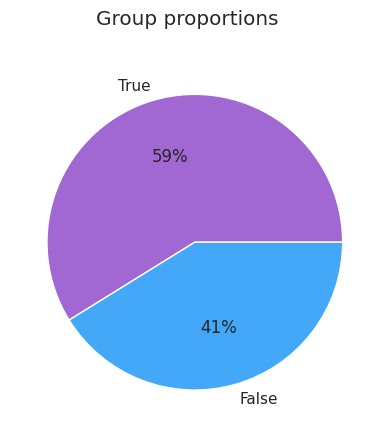

In [ ]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(group_a)

In [ ]:
X = df_clean.iloc[:,:-1].values
y = df_clean.iloc[:,-1].values

X.shape, y.shape

((1025, 42), (1025,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

In [ ]:
# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from holisticai.pipeline import Pipeline
# efficacy metrics from sklearn
from sklearn import metrics

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,
        "Precision": metrics.precision_score,
        "Recall": metrics.recall_score,
        "F1-Score": metrics.f1_score}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train a simple linear classification model
LR = LogisticRegression()
model = LR.fit(X, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

# Predict values
y_pred = model.predict(X)

y_proba = model.predict_proba(X)
y_score = y_proba[:,1]
y_true = y
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.878049
Balanced accuracy,0.517222
Precision,0.500000
Recall,0.040000
F1-Score,0.074074


In [ ]:
from holisticai.bias.metrics import classification_bias_metrics
df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
y_baseline = y_pred.copy()
df_baseline=df.copy()
df_baseline

,Value,Reference
Metric,,
Statistical Parity,0.018018,0
Disparate Impact,inf,1
Four Fifths Rule,0.000000,1
Cohen D,0.184015,0
2SD Rule,1.307815,0
Equality of Opportunity Difference,0.062500,0
False Positive Rate Difference,0.010526,0
Average Odds Difference,0.036513,0
Accuracy Difference,-0.048399,0


**Correlation remover: Preprocessing method**

In [ ]:
from holisticai.bias.mitigation import CorrelationRemover
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = CorrelationRemover()

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression()

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem = df.copy()
df_corr_rem

,Value,Reference
Metric,,
Statistical Parity,0.018018,0
Disparate Impact,inf,1
Four Fifths Rule,0.000000,1
Cohen D,0.184015,0
2SD Rule,1.307815,0
Equality of Opportunity Difference,0.062500,0
False Positive Rate Difference,0.010526,0
Average Odds Difference,0.036513,0
Accuracy Difference,-0.048399,0


In [ ]:
model = LogisticRegression()
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", model),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem_w_p =df.copy()
df_corr_rem_w_p

,Value,Reference
Metric,,
Statistical Parity,0.018018,0
Disparate Impact,inf,1
Four Fifths Rule,0.000000,1
Cohen D,0.184015,0
2SD Rule,1.307815,0
Equality of Opportunity Difference,0.062500,0
False Positive Rate Difference,0.010526,0
Average Odds Difference,0.036513,0
Accuracy Difference,-0.048399,0


In [ ]:
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)


,Value
Metric,
Accuracy,0.878049
Balanced accuracy,0.517222
Precision,0.500000
Recall,0.040000
F1-Score,0.074074


In [ ]:
result = pd.concat([df_baseline, df_corr_rem, df_corr_rem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Statistical Parity,0.018018,0.018018,0.018018,0
Disparate Impact,inf,inf,inf,1
Four Fifths Rule,0.000000,0.000000,0.000000,1
Cohen D,0.184015,0.184015,0.184015,0
2SD Rule,1.307815,1.307815,1.307815,0
Equality of Opportunity Difference,0.062500,0.062500,0.062500,0
False Positive Rate Difference,0.010526,0.010526,0.010526,0
Average Odds Difference,0.036513,0.036513,0.036513,0
Accuracy Difference,-0.048399,-0.048399,-0.048399,0


In [ ]:
def calculate_metrics(train_data, test_data, alpha, metrics_cols):
  from sklearn.metrics import accuracy_score
  model = LogisticRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", CorrelationRemover(alpha=alpha)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  df = classification_bias_metrics(
      group_a,
      group_b,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      alpha,
      accuracy_score(y, y_pred)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Statistical Parity', 'Disparate Impact']

for alphas in np.linspace(0,1.5,12):
  metrics_val.append(calculate_metrics(train_data, test_data, alphas, metrics_cols))

metrics = ['alpha', 'accuracy']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,alpha,accuracy,Statistical Parity,Disparate Impact
0,0.000000,0.878049,0.018018,inf
1,0.136364,0.878049,0.018018,inf
2,0.272727,0.878049,0.018018,inf
3,0.409091,0.878049,0.018018,inf
4,0.545455,0.878049,0.018018,inf
5,0.681818,0.878049,0.018018,inf
6,0.818182,0.878049,0.018018,inf
7,0.954545,0.878049,0.018018,inf
8,1.090909,0.878049,0.018018,inf
9,1.227273,0.878049,0.018018,inf


Text(0.5, 0, 'alpha')

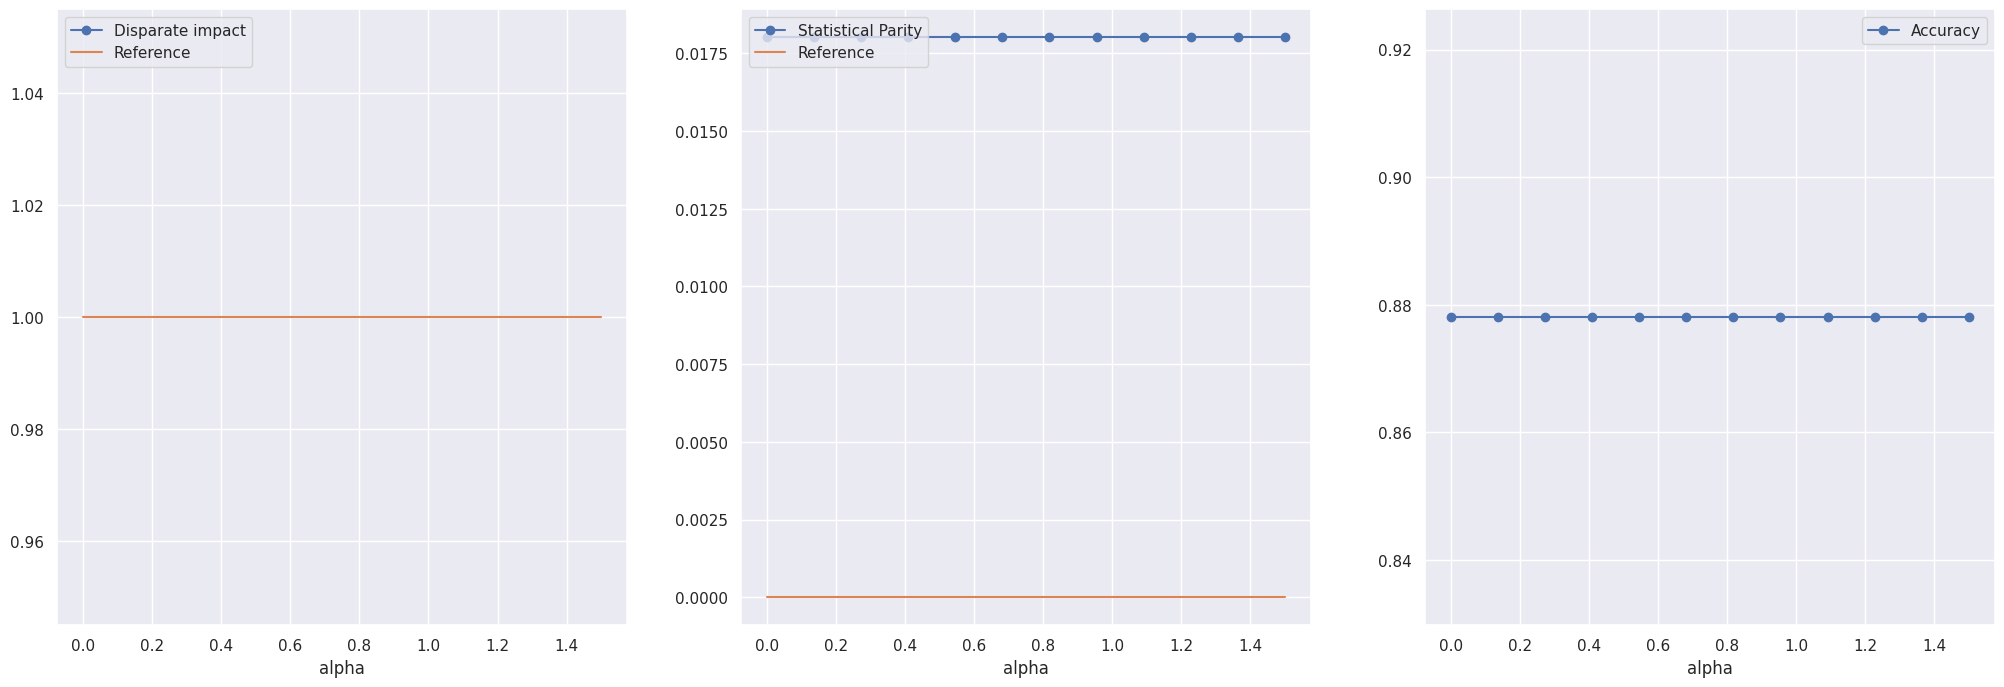

In [ ]:
import matplotlib.pyplot as plt
x_axis = df_metrics.alpha
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Disparate Impact'], 'o-', label='Disparate impact')
plt.plot(x_axis, np.ones_like(df_metrics['Disparate Impact']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Statistical Parity'], 'o-', label='Statistical Parity')
plt.plot(x_axis, np.zeros_like(df_metrics['Statistical Parity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(133)
plt.plot(x_axis, df_metrics['accuracy'], 'o-', label='Accuracy')
plt.legend(loc='upper right')
plt.xlabel('alpha')

**Disparate impact remover: Preprocessing method**

In [ ]:
from holisticai.bias.mitigation import DisparateImpactRemover
from sklearn.preprocessing import StandardScaler,MinMaxScaler

X, y, group_a, group_b = train_data

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = DisparateImpactRemover(repair_level=1.0)

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression(class_weight='balanced', solver='liblinear')

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_disprem = df.copy()
df_disprem

,Value,Reference
Metric,,
Statistical Parity,-0.073414,0
Disparate Impact,0.797032,1
Four Fifths Rule,0.797032,1
Cohen D,-0.157615,0
2SD Rule,-1.120988,0
Equality of Opportunity Difference,-0.118056,0
False Positive Rate Difference,-0.078019,0
Average Odds Difference,-0.098037,0
Accuracy Difference,0.044758,0


In [ ]:
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.673171
Balanced accuracy,0.590000
Precision,0.181818
Recall,0.480000
F1-Score,0.263736


In [ ]:
model = LogisticRegression(class_weight='balanced', solver='liblinear')
pipeline = Pipeline(
    steps=[
        ('scalar', MinMaxScaler()),
        ("bm_preprocessing", DisparateImpactRemover()),
        ("model", model),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_disprem_w_p =df.copy()
df_disprem_w_p

,Value,Reference
Metric,,
Statistical Parity,-0.073414,0
Disparate Impact,0.797032,1
Four Fifths Rule,0.797032,1
Cohen D,-0.157615,0
2SD Rule,-1.120988,0
Equality of Opportunity Difference,-0.118056,0
False Positive Rate Difference,-0.078019,0
Average Odds Difference,-0.098037,0
Accuracy Difference,0.044758,0


In [ ]:
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.673171
Balanced accuracy,0.590000
Precision,0.181818
Recall,0.480000
F1-Score,0.263736


In [ ]:
result = pd.concat([df_baseline, df_disprem, df_disprem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Statistical Parity,0.018018,-0.073414,-0.073414,0
Disparate Impact,inf,0.797032,0.797032,1
Four Fifths Rule,0.000000,0.797032,0.797032,1
Cohen D,0.184015,-0.157615,-0.157615,0
2SD Rule,1.307815,-1.120988,-1.120988,0
Equality of Opportunity Difference,0.062500,-0.118056,-0.118056,0
False Positive Rate Difference,0.010526,-0.078019,-0.078019,0
Average Odds Difference,0.036513,-0.098037,-0.098037,0
Accuracy Difference,-0.048399,0.044758,0.044758,0


In [ ]:
def calculate_metrics(train_data, test_data, repair_level, metrics_cols):
  from sklearn.metrics import accuracy_score
  model = LogisticRegression(class_weight='balanced', solver='liblinear')
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", DisparateImpactRemover(repair_level=repair_level)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  df = classification_bias_metrics(
      group_a,
      group_b,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      repair_level,
      accuracy_score(y, y_pred)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Statistical Parity', 'Disparate Impact']

for repair_values in np.linspace(0,1,11):
  metrics_val.append(calculate_metrics(train_data, test_data, repair_values, metrics_cols))

metrics = ['repair_value', 'Accuracy']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,repair_value,Accuracy,Statistical Parity,Disparate Impact
0,0.0,0.604878,-0.163408,0.658659
1,0.1,0.604878,-0.163408,0.658659
2,0.2,0.590244,-0.175676,0.648649
3,0.3,0.595122,-0.165037,0.662750
4,0.4,0.595122,-0.165037,0.662750
5,0.5,0.600000,-0.154399,0.677477
6,0.6,0.663415,-0.094690,0.752753
7,0.7,0.653659,-0.115967,0.713134
8,0.8,0.653659,-0.115967,0.713134
9,0.9,0.648780,-0.126605,0.694849


Text(0.5, 0, 'repair_value')

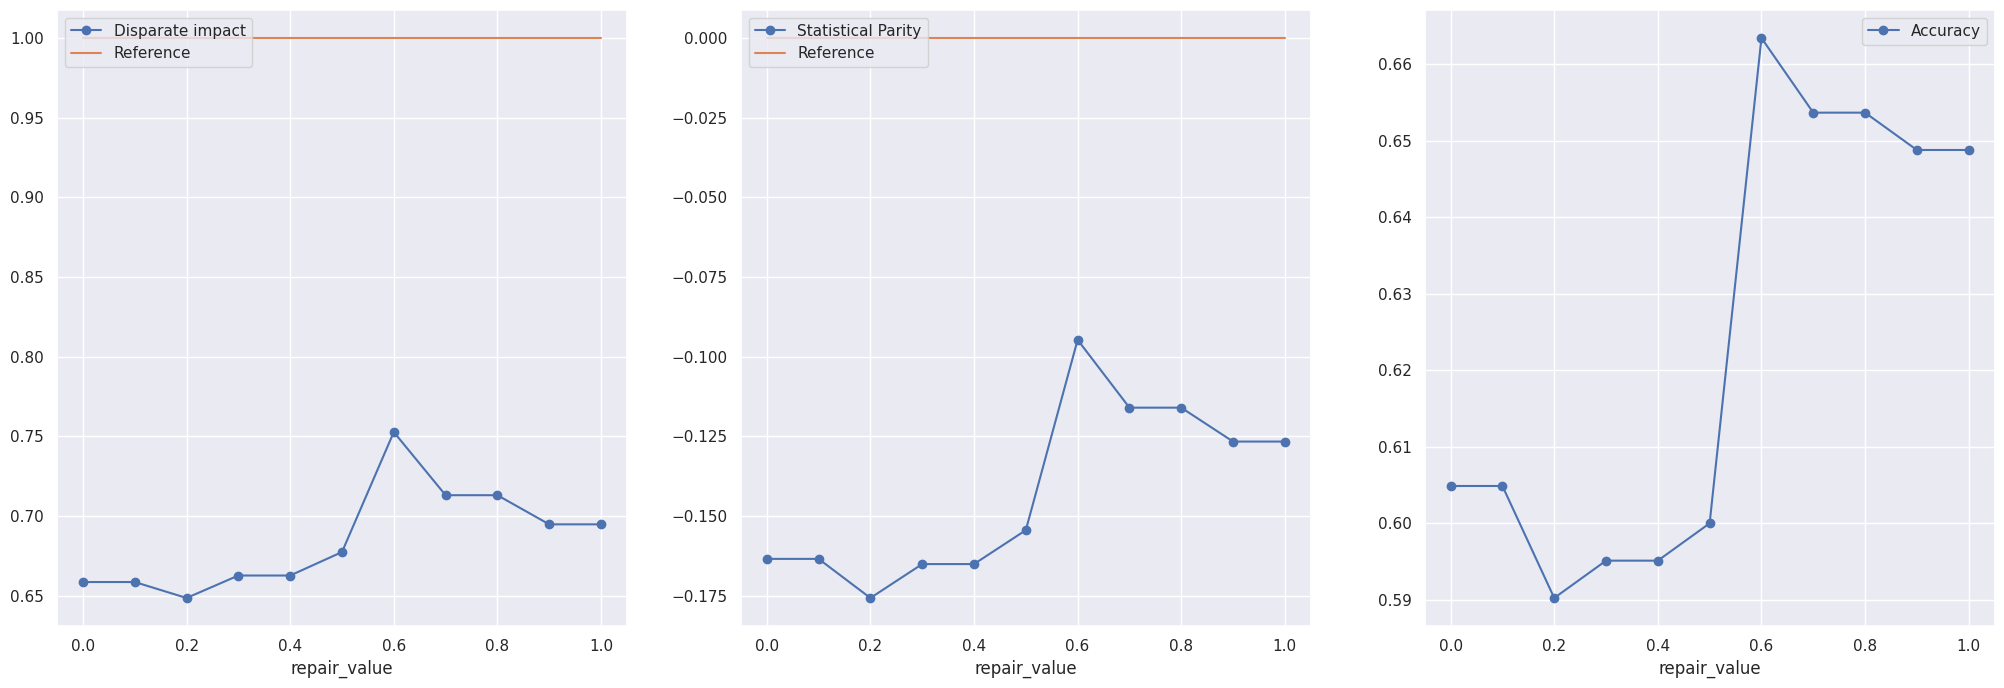

In [ ]:
x_axis = df_metrics.repair_value
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Disparate Impact'], 'o-', label='Disparate impact')
plt.plot(x_axis, np.ones_like(df_metrics['Disparate Impact']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('repair_value')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Statistical Parity'], 'o-', label='Statistical Parity')
plt.plot(x_axis, np.zeros_like(df_metrics['Statistical Parity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('repair_value')
plt.subplot(133)
plt.plot(x_axis, df_metrics['Accuracy'], 'o-', label='Accuracy')
plt.legend(loc='upper right')
plt.xlabel('repair_value')